This script solves the canonical Atkeson Burstein (2008) model. Emphasis has been placed on performance and scalability. JAX also allows for seemless parallelization across GPUs.

In [13]:
import os
import multiprocessing

# Get the number of available CPU cores
n_cores = multiprocessing.cpu_count()

# Set number of devices to use
os.environ["XLA_FLAGS"] = f'--xla_force_host_platform_device_count={max(1, n_cores - 2)}'

import jax
n_devices = jax.device_count()
print(f"Number of devices: {n_devices}")

Number of devices: 6


In [14]:
import numpy as np
import jax.numpy as jnp
from jax import jit, vmap, pmap
import time

from jaxopt import AndersonAcceleration
import optimistix as optx

jax.config.update('jax_enable_x64', True)

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style="whitegrid") 
sns.set_palette("muted")

In [15]:
"""
    Fixed point options: 
    --------------------
    0: AA for market shares
    1: AA for prices
    2: TrustRegion for shares
    3: TrustRegion for prices
"""

fxp_type = 3
if fxp_type == 0:
    print("Anderson Acceleration for market shares")
elif fxp_type == 1:
    print("Anderson Acceleration for prices")
elif fxp_type == 2:
    print("TrustRegion for market shares")
elif fxp_type == 3:
    print("TrustRegion for prices")

TrustRegion for prices


In [16]:
@jit
def get_elast_inv(s, par):
    '''
    Computes the elasticity of demand for the Cournot competition case.

    Parameters
    ----------
    s: (K,1) array of market shares for firms 1, ..., K
    '''
    return s / par['eta'] + (1 - s) / par['rho']

@jit
def get_markup(s, par):
    '''
    Computes markup given demand elasticity.
    '''
    
    e_inv = get_elast_inv(s, par)
    m = 1. / (1. - e_inv)
    
    return m

@jit 
def get_market_shares(p, par):
    '''
    Computes market shares given prices.
    
    Parameters
    ----------
    p: (K,) array of prices for firms 1, ..., K
    '''
    
    s = p ** (1 - par['rho'])
    s /= jnp.sum(s)
    
    return s

@jit
def update_s_(s, z, par):
    '''
    For a guess s^n computes an update for the market shares given the productivities of all other
    firms.
    
    Parameters
    ----------
    s: (K,) array of (initial guess for) market shares for firms 1, ..., K
    z: (K,) array of productivities for firms 1, ..., K
    '''
    
    m = get_markup(s, par)
    snew = (z / m) ** (par['rho'] - 1)
    snew /= jnp.sum(snew)

    return snew

@jit
def update_p_(p, z, par):
    '''
    For a guess s^n computes an update for the price vector given the productivities of all other
    firms.
    
    Parameters
    ----------
    p: (K,) array of (initial guess for) prices for firms 1, ..., K
    z: (K,) array of productivities for firms 1, ..., K
    '''
    
    s = get_market_shares(p, par)
    m = get_markup(s, par)
    pnew = m / z

    return pnew

Define Anderson Acceleration object. See https://jaxopt.github.io/stable/fixed_point.html#anderson-acceleration or https://arxiv.org/pdf/1909.04638.

In [17]:
# Fixed point iteration for market shares
aa = AndersonAcceleration(fixed_point_fun=update_s_, history_size=2, ridge=100, 
                          tol=1e-8, maxiter=100_000) 

@jit
def solve_AK_aa(par, s_init, z):
    s, state = aa.run(s_init.copy(), z, par)
    m = get_markup(s, par)

    return (s, m, state.error < 1e-6, state.error, state.iter_num)

# Fixed point iteration for prices
aa_p = AndersonAcceleration(fixed_point_fun=update_p_, history_size=5, ridge=10., 
                            tol=1e-8, maxiter=10_000)

@jit 
def solve_AK_aa_p(par, p_init, z):
    p = aa_p.run(p_init.copy(), z, par).params
    s = get_market_shares(p, par)

    # Check convergence
    err = jnp.max(jnp.abs(s - update_s_(s, z, par)))
    convergence_failed = jax.lax.cond(err < 1e-6, lambda x: 0, lambda x: 1, None)

    return (p, s, convergence_failed)   

In [18]:
# Using a Trust Region method
solver = optx.Dogleg(rtol=1e-8, atol=1e-8)

@jit 
def solve_AK_dogleg(par, s_init, z):
    sol = optx.root_find(lambda x, _: x - update_s_(x, z, par), solver, s_init.copy())    
    s = sol.value
    m = get_markup(s, par)

    err = jnp.max(jnp.abs(s - update_s_(s, z, par)))

    return (s, m, err)

# Equivalent for FP for prices
@jit 
def solve_AK_dogleg_p(par, p_init, z):
    sol = optx.root_find(lambda x, _: x - update_p_(x, z, par), solver, p_init.copy())    
    p = sol.value
    s = get_market_shares(p, par)

    err = jnp.max(jnp.abs(s - update_s_(s, z, par)))

    return (p, s, err)

In [19]:
# Set-up
par = {'K': 20, # firms per sector
       'N': 20_000, # number of sectors (n_firms = K*N)
       'theta': 0.385, # productivity distribution log z ~ N(0, theta); could be sector specific
       'eta': 1.01,
       'rho': 10.0}

# Initialise firms / draws from the productivity distribution
rng = jax.random.PRNGKey(200812)
eps_z = jax.random.normal(rng, (n_devices, np.ceil(par['N'] / n_devices).astype(int), par['K']))
z = jnp.exp(eps_z * par['theta'])
z = jnp.sort(z, axis=2)

# Initial guess for market share and prices
s_init = (1. / par['K']) * jnp.ones(par['K'])
p_init = update_p_(jnp.ones_like(s_init), z[0, 0, :], par)

In [20]:
start = time.time()
if fxp_type == 0:
    shares, markups, flag, diff, iter_num = jax.pmap(jax.vmap(lambda x: solve_AK_aa(par, s_init, x)))(z)
    prices = markups / z
elif fxp_type == 1:
    prices, shares, flag = jax.pmap(jax.vmap(lambda x: solve_AK_aa_p(par, p_init, x)))(z)
    markups = prices * z
elif fxp_type == 2:
    shares, markups, errs = jax.pmap(jax.vmap(lambda x: solve_AK_dogleg(par, s_init, x)))(z)
    prices = markups / z
    assert jnp.max(errs) < 1e-8
elif fxp_type == 3:
    prices, shares, errs = jax.pmap(jax.vmap(lambda x: solve_AK_dogleg_p(par, p_init, x)))(z)
    markups = prices * z
    assert jnp.max(errs) < 1e-8

# Reshape the outputs
prices = prices.reshape(-1, prices.shape[-1])
shares = shares.reshape(-1, shares.shape[-1])
markups = markups.reshape(-1, markups.shape[-1])

HHI = jnp.sum(100 * shares ** 2, axis=1)
end = time.time()

print('Time elapsed: ', end - start, ' seconds')
print('Time elapsed: ', (end - start) / 60, ' minutes')

Time elapsed:  4.428667783737183  seconds
Time elapsed:  0.07381112972895304  minutes


/home/stephan/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/stephan/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/stephan/anaconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


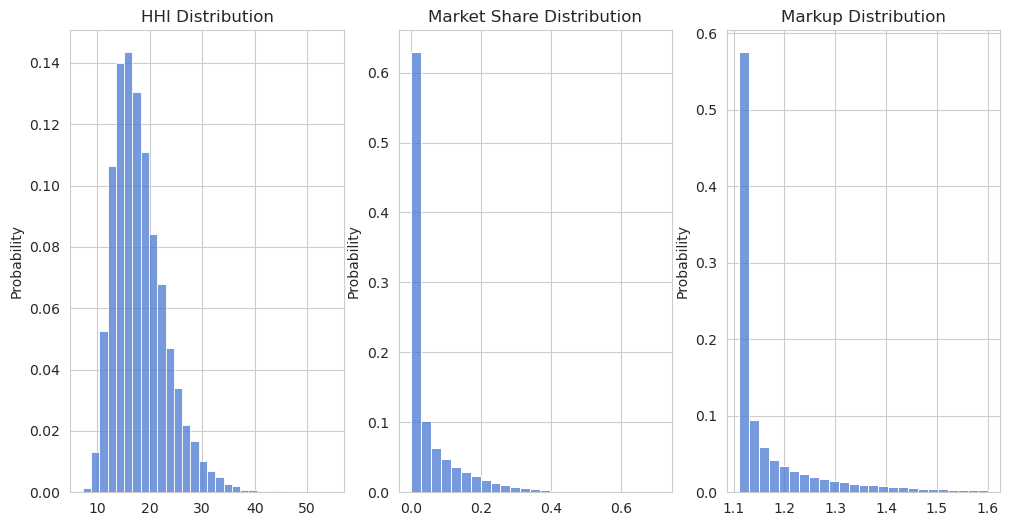

In [21]:
# Histograms of distribution within sector
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))
ax1.set_title('HHI Distribution')
ax2.set_title('Market Share Distribution')
ax3.set_title('Markup Distribution')

sns.histplot(ax=ax1, x=HHI, stat='probability', bins=30)
sns.histplot(ax=ax2, x=shares.flatten(), stat='probability', bins = 25)
sns.histplot(ax=ax3, x=markups[markups <= 1.6].flatten(), stat='probability', bins = 25)
plt.show()

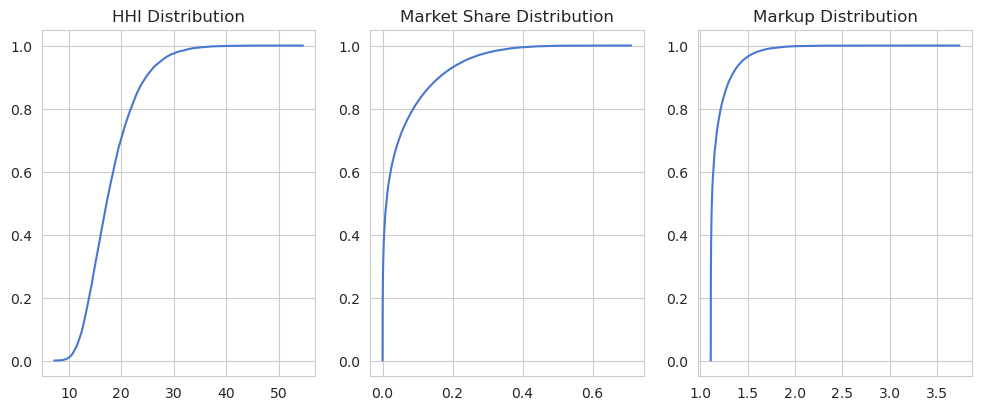

In [22]:
# Plot empirical cdf
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4.5))
ax1.set_title('HHI Distribution')
ax2.set_title('Market Share Distribution')
ax3.set_title('Markup Distribution')

ax1.plot(np.sort(HHI), np.arange(len(HHI))/float(len(HHI)))
ax2.plot(np.sort(shares.flatten()), np.arange(len(shares.flatten()))/float(len(shares.flatten())))
ax3.plot(np.sort(markups.flatten()), np.arange(len(markups.flatten()))/float(len(markups.flatten())))

plt.show()

(1.0, 3.0)

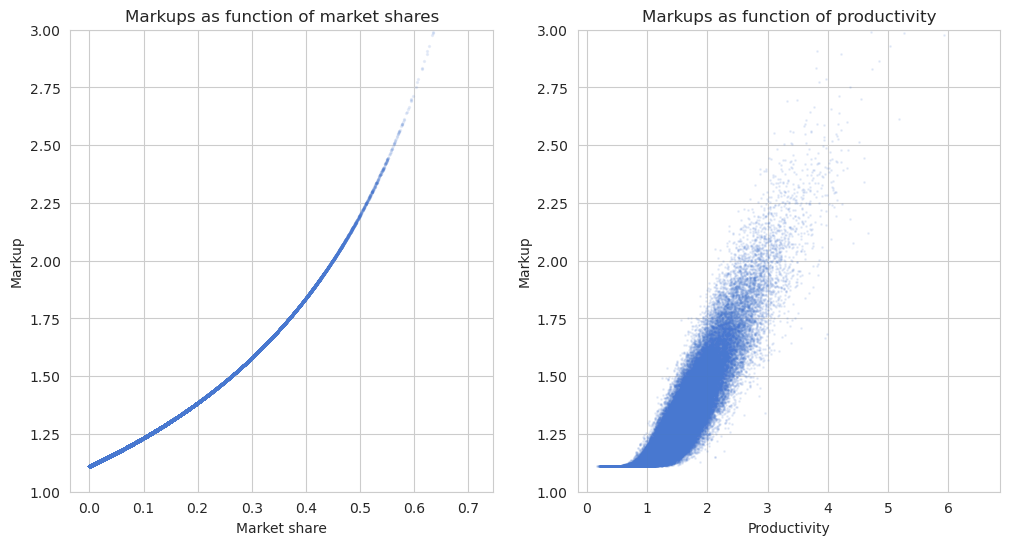

In [23]:
# Scatterplot of market shares and markups
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

ax1.scatter(shares.flatten(), markups.flatten(), s=2, alpha=0.1)
ax1.set_title('Markups as function of market shares')
ax1.set_xlabel('Market share')
ax1.set_ylabel('Markup')
ax1.set_ylim(1, 3.)

ax2.scatter(z.flatten(), markups.flatten(), s=1, alpha=0.1)
ax2.set_title('Markups as function of productivity')
ax2.set_xlabel('Productivity')
ax2.set_ylabel('Markup')
ax2.set_ylim(1, 3.)